# Truth-set somatic SNVs

In [2]:
import io
import os
import numpy as np
import pandas as pd
import gzip as gz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib_venn import venn2, venn3

sns.set_theme(font="Arial", font_scale=1.15, style='ticks') 
matplotlib.rcParams['figure.dpi'] = 300
plt.rc("axes.spines", top=False, right=False)

def read_vcf(path):
    if path[-3:] == ".gz": 
        with gz.open(path, 'rb') as f:
            lines = [l.decode('utf-8') for l in f if not l.startswith(b'##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})
    else:
        with open(path, 'r') as f:
            lines = [l for l in f if not l.startswith('##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})

def vcf_format_getter(df, field) -> pd.Series:
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        GT, VAF, DP, AD
    
    return pd.Series

    Example vcf structure
    ----------
    FORMAT              COLO829T_PassageB_DSA  
    GT:GQ:DP:AD:VAF:PL  1/1:59:133:2,131:0.984962:65,60,0
    GT:GQ:DP:AD:VAF:PL  1/1:65:131:0,131:1:70,66,0
    GT:GQ:DP:AD:VAF:PL  1/1:53:49:0,49:1:58,54,0

    """
    sampleid = df.columns[9]
    format = list(set(df['FORMAT'].values))[0].split(':')

    if field == "GT":
        gtindex = format.index('GT')
        return df[sampleid].str.split(':').apply(lambda x: x[gtindex])
    
    elif field == "VAF":
        vafindex = format.index('VAF')
        return df[sampleid].str.split(':').apply(lambda x: float(x[vafindex]))
    
    elif field == "DP":
        dpindex = format.index('DP')
        return df[sampleid].str.split(':').apply(lambda x: int(x[dpindex]))
    
    elif field == "AD":
        adindex = format.index('AD')
        return df[sampleid].str.split(':').apply(lambda x: int(x[adindex].split(',')[1]))
    
    else:
        raise ValueError("field should be one of GT, VAF, DP and AD!")

def vcf_info_parser(info_string) -> dict:
    """
    Parameters
    ----------
    info_string : str
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1

    return dict

    """
    return {i.split('=')[0]: i.split('=')[1] for i in info_string.split(';')}

def vcf_info_getter(df, field):
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        VAF_Ill, VAF_PB
    
    return pd.Series

    Example vcf structure
    ----------
    INFO
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1
    SP=STK,RF,MT2,VN;RGN=Easy;RGN_T=Tier0;VAF_Ill=0.981;VAF_PB=0.984
    """

    if field == "VAF_Ill" or field == "VAF_PB":
        return df['INFO'].apply(lambda x: float(vcf_info_parser(x)[field]) if vcf_info_parser(x)[field] != 'NA' else np.nan)

    else:
        return df['INFO'].apply(lambda x: vcf_info_parser(x).get(field))

def make_site_list(df: pd.DataFrame, path: str, prefix: str) -> None:
    """
    Parameters
    ----------
    df : pandas.core.frame.DataFrame 
        vcf read through read_vcf()
    path : str

    prefix : str

    return target_list 
    """
    
    df = df[['CHROM', 'POS', 'POS']].drop_duplicates()
    
    df.to_csv(f"{os.path.join(path, prefix)}.sitelist", sep='\t', index=False, header=False)

def get_pileup_nonref_snvid_from_bamreadcount(string):
	"""
    Parameters
    ----------
    haplotype1-0000001      33514324        C       163     =:0:0.00:0.00:0.00:0:0:0.00:0.00:0.00:0:0.00:0.00:0.00  A:0:0.00:0.00:0.00:0:0:0.00:0.00:0.00:0:0.00:0.00:0.00  C:163:60.00:37.20:60.00:77:86:0.45:0.00:85.27:77:0.52:21136.30:0.50     G:0:0.00:0.00:0.00:0:0:0.00:0.00:0.00:0:0.00:0.00:0.00  T:0:0.00:0.00:0.00:0:0:0.00:0.00:0.00:0:0.00:0.00:0.00  N:0:0.00:0.00:0.00:0:0:0.00:0.00:0.00:0:0.00:0.00:0.00  +A:1:60.00:0.00:60.00:0:1:0.38:0.01:268.00:0:0.00:23061.00:0.81
    """
	threshold = 1
	
	string2list = string.strip().split()
	preid = f"{'_'.join(string2list[:3])}_"
	
	snvid_list = list()
	
	for s in string2list[5:9]:
		s = s.split(':')
		if s[0] != string2list[2] and int(s[1]) >= threshold:
			snvid_list.append(preid + s[0])
	
	return snvid_list

dir="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq"

DSA="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/DSA/DSA_COLO829BL_v3.0.0.fasta"

In [3]:
colobl_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829BL/deepvariant/COLO829BL.deepvariant.PASS.snv.annot.vcf.gz")
colotb_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.vcf.gz")
colota_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.vcf.gz")

In [4]:
colobl_vcf['SNVid'] = colobl_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colotb_vcf['SNVid'] = colotb_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colota_vcf['SNVid'] = colota_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

colobl_snvs_set = set(colobl_vcf['SNVid'].values)
colotb_snvs_set = set(colotb_vcf['SNVid'].values)
colota_snvs_set = set(colota_vcf['SNVid'].values)

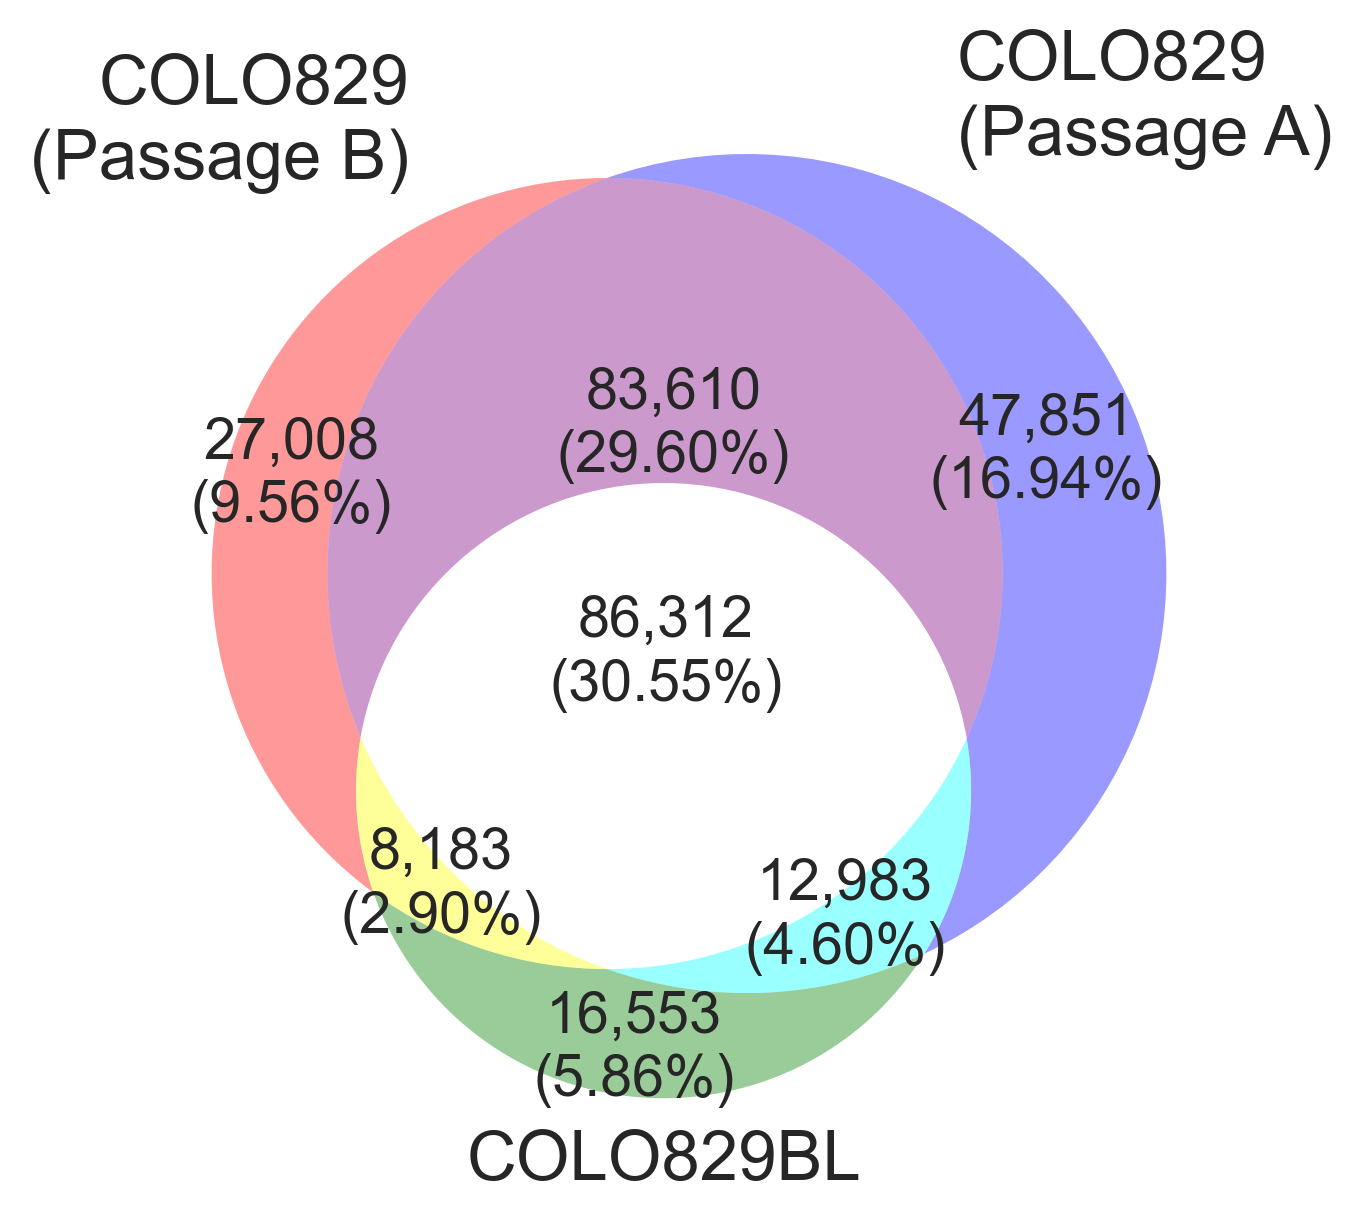

In [5]:
total = len((colotb_snvs_set.union(colota_snvs_set)).union(colobl_snvs_set))
venn = venn3([colotb_snvs_set, colota_snvs_set, colobl_snvs_set], 
             ('COLO829\n(Passage B)', 'COLO829\n(Passage A)', 'COLO829BL'),
             subset_label_formatter=lambda x: f"{x:,}\n({(x/total):.2%})")
venn.get_patch_by_id('100').set_color('red')
venn.get_patch_by_id('010').set_color('blue')
venn.get_patch_by_id('001').set_color('green')
venn.get_patch_by_id('110').set_color('purple')
venn.get_patch_by_id('101').set_color('yellow')
venn.get_patch_by_id('011').set_color('cyan')
venn.get_patch_by_id('111').set_color('white')


for i in ['100', '010', '001', '110', '101', '011', '111']:
    venn.get_patch_by_id(i).set_edgecolor('none')
    venn.get_patch_by_id(i).set_alpha(0.4)

In [6]:
colotb_snvs_correct = colotb_vcf[(vcf_info_getter(colotb_vcf, "Flagger") == "Hap") & (vcf_info_getter(colotb_vcf, "NucFlag").isna())]
colota_snvs_correct = colota_vcf[(vcf_info_getter(colota_vcf, "Flagger") == "Hap") & (vcf_info_getter(colota_vcf, "NucFlag").isna())]

In [7]:
colot_snvs_gl_pileupcheck_set =  colotb_snvs_set.union(colota_snvs_set).difference(colobl_snvs_set)

colotb_snvs_glfilt = colotb_snvs_correct[colotb_snvs_correct["SNVid"].isin(colot_snvs_gl_pileupcheck_set)]

make_site_list(colotb_snvs_glfilt,
               path=f'{dir}/VariantCalls_DeepVariant_1.6.1', 
               prefix="COLO829TB_SNVs_Germline_PileupCheck")

colota_snvs_glfilt = colota_snvs_correct[colota_snvs_correct["SNVid"].isin(colot_snvs_gl_pileupcheck_set)]

make_site_list(colota_snvs_glfilt,
               path=f'{dir}/VariantCalls_DeepVariant_1.6.1', 
               prefix="COLO829TA_SNVs_Germline_PileupCheck")

os.system(f"cat \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TB_SNVs_Germline_PileupCheck.sitelist \
            {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TA_SNVs_Germline_PileupCheck.sitelist \
                | sort | uniq | bedtools sort -i - > {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TBA_SNVs_Germline_PileupCheck.sitelist")

os.system(f"rm \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TB_SNVs_Germline_PileupCheck.sitelist \
            {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TA_SNVs_Germline_PileupCheck.sitelist")

0

In [8]:
# open up the bcftools mpileup vcf and filter out
# Convert test2.vcf.gz to COLO829BL_Pileup_on_COLO829TBA_SNVs_Germline_PileupCheck.sitelist.norm.vcf.gz
colobl_pileupglfilt_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829BL_Pileup_on_COLO829TBA_SNVs_Germline_PileupCheck.sitelist.norm.reheader.vcf.gz")
colobl_pileupglfilt_vcf['SNVid'] = colobl_pileupglfilt_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

colobl_snvs_gl_pileupcheck_set = set(colobl_pileupglfilt_vcf['SNVid'])

In [9]:
colotb_snvs_final = colotb_snvs_correct[(~colotb_snvs_correct["SNVid"].isin(colobl_snvs_set)) & (~colotb_snvs_correct["SNVid"].isin(colobl_snvs_gl_pileupcheck_set))].reset_index(drop=True)
colota_snvs_final = colota_snvs_correct[(~colota_snvs_correct["SNVid"].isin(colobl_snvs_set)) & (~colota_snvs_correct["SNVid"].isin(colobl_snvs_gl_pileupcheck_set))].reset_index(drop=True)
colotb_snvs_finalset = set(colotb_snvs_final['SNVid'].values)
colota_snvs_finalset = set(colota_snvs_final['SNVid'].values)

colot_shared_finalset = colotb_snvs_finalset.intersection(colota_snvs_finalset)
colotb_specific_finalset = colotb_snvs_finalset.difference(colot_shared_finalset)
colota_specific_finalset = colota_snvs_finalset.difference(colot_shared_finalset)

colotb_snvs_shared_final = colotb_snvs_final[colotb_snvs_final["SNVid"].isin(colot_shared_finalset)].reset_index(drop=True)
colota_snvs_shared_final = colota_snvs_final[colota_snvs_final["SNVid"].isin(colot_shared_finalset)].reset_index(drop=True)

colotb_snvs_bspecific_final = colotb_snvs_final[colotb_snvs_final["SNVid"].isin(colotb_specific_finalset)].reset_index(drop=True)
colota_snvs_aspecific_final = colota_snvs_final[colota_snvs_final["SNVid"].isin(colota_specific_finalset)].reset_index(drop=True)

# colotb_snvs_final, colotb_snvs_shared_final, colotb_snvs_bspecific_final
# colota_snvs_final, colota_snvs_shared_final, colota_snvs_bspecific_final

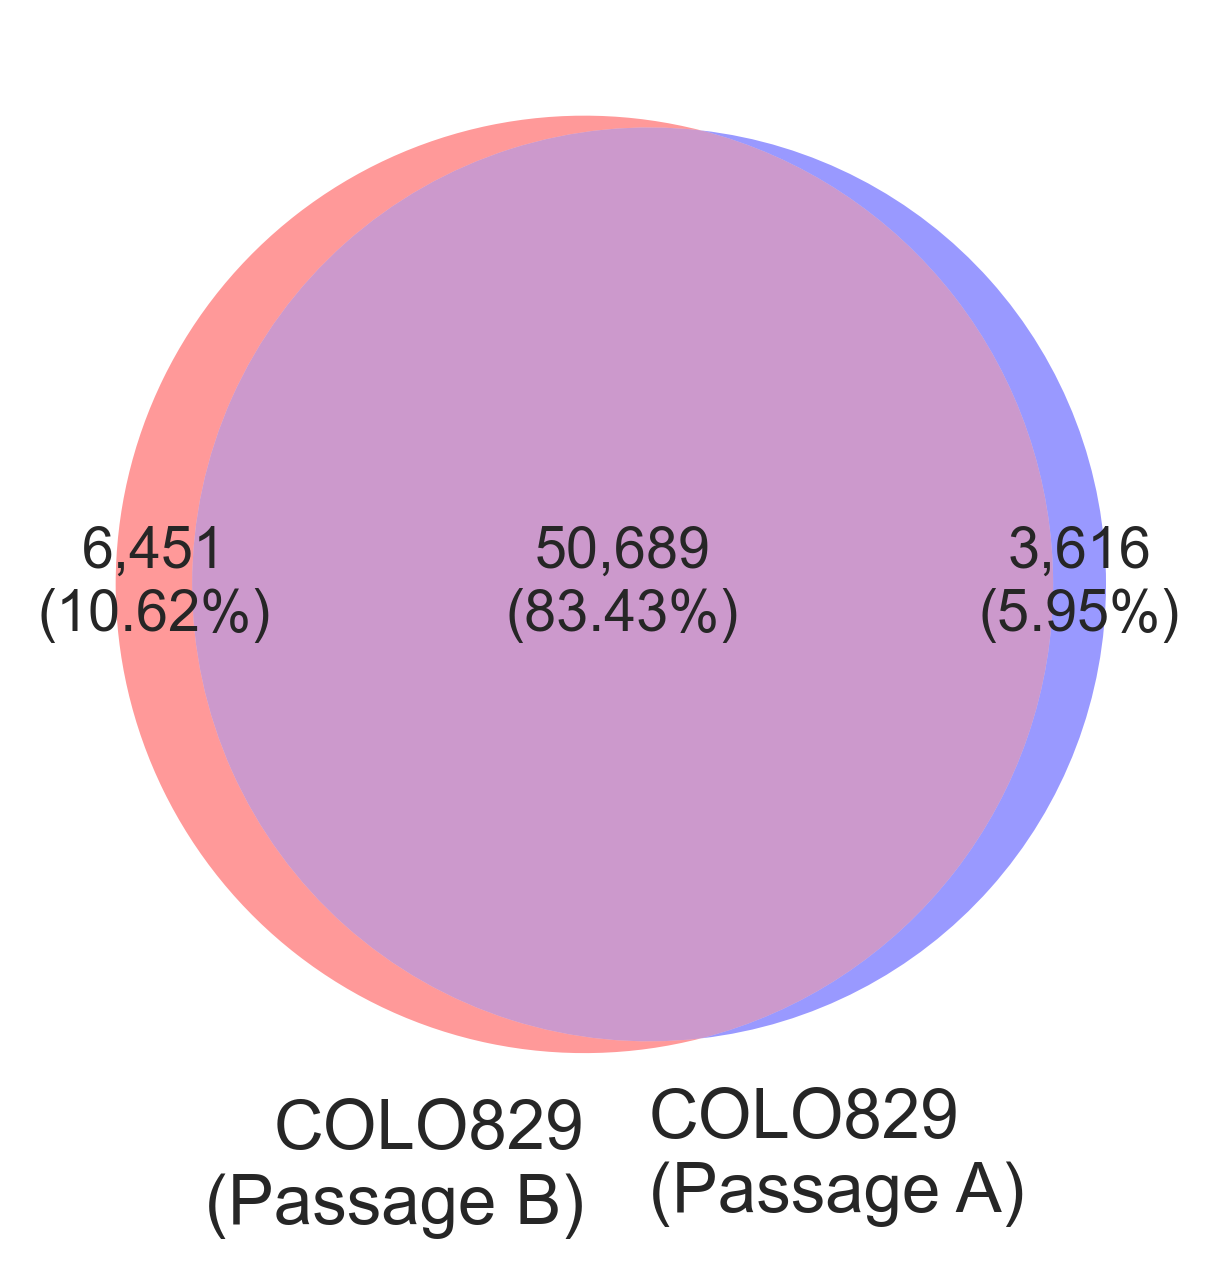

In [10]:
total = len((colotb_snvs_finalset.union(colota_snvs_finalset)))
venn = venn2([colotb_snvs_finalset, colota_snvs_finalset], 
             ('COLO829\n(Passage B)', 'COLO829\n(Passage A)'),
             subset_label_formatter=lambda x: f"{x:,}\n({(x/total):.2%})")
venn.get_patch_by_id('10').set_color('red')
venn.get_patch_by_id('01').set_color('blue')
venn.get_patch_by_id('11').set_color('purple')

for i in ['10', '01', '11']:
    venn.get_patch_by_id(i).set_edgecolor('none')
    venn.get_patch_by_id(i).set_alpha(0.4)

In [11]:
colotb_snvs_final

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829T_PassageB_DSA,SNVid
0,haplotype1-0000001,345669,.,C,T,65,PASS,Flagger=Hap;RM=LINE/L1,GT:GQ:DP:AD:VAF:PL,"1/1:59:133:2,131:0.984962:65,60,0",haplotype1-0000001_345669_C_T
1,haplotype1-0000001,381602,.,G,T,70.4,PASS,Flagger=Hap;RM=LINE/L1,GT:GQ:DP:AD:VAF:PL,"1/1:65:131:0,131:1:70,66,0",haplotype1-0000001_381602_G_T
2,haplotype1-0000001,436345,.,G,A,58.7,PASS,"Flagger=Hap;TRF=trf_191/178.1/36/94/1.51,trf_1...",GT:GQ:DP:AD:VAF:PL,"1/1:53:49:0,49:1:58,54,0",haplotype1-0000001_436345_G_A
3,haplotype1-0000001,493800,.,G,A,68.7,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:63:83:0,83:1:68,63,0",haplotype1-0000001_493800_G_A
4,haplotype1-0000001,547974,.,A,G,71.3,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:65:123:0,123:1:71,66,0",haplotype1-0000001_547974_A_G
...,...,...,...,...,...,...,...,...,...,...,...
57135,haplotype2-0000079,171322181,.,G,A,60.7,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:55:57:0,57:1:60,56,0",haplotype2-0000079_171322181_G_A
57136,haplotype2-0000079,171322182,.,G,A,63,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:61:57:0,57:1:63,64,0",haplotype2-0000079_171322182_G_A
57137,haplotype2-0000079,171499461,.,C,T,62.8,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:59:53:0,53:1:62,62,0",haplotype2-0000079_171499461_C_T
57138,haplotype2-0000128,350278,.,A,T,14.7,PASS,Flagger=Hap;RM=Satellite/unknown;TRF=trf_25140...,GT:GQ:DP:AD:VAF:PL,"0/1:13:4:2,2:0.5:14,0,16",haplotype2-0000128_350278_A_T


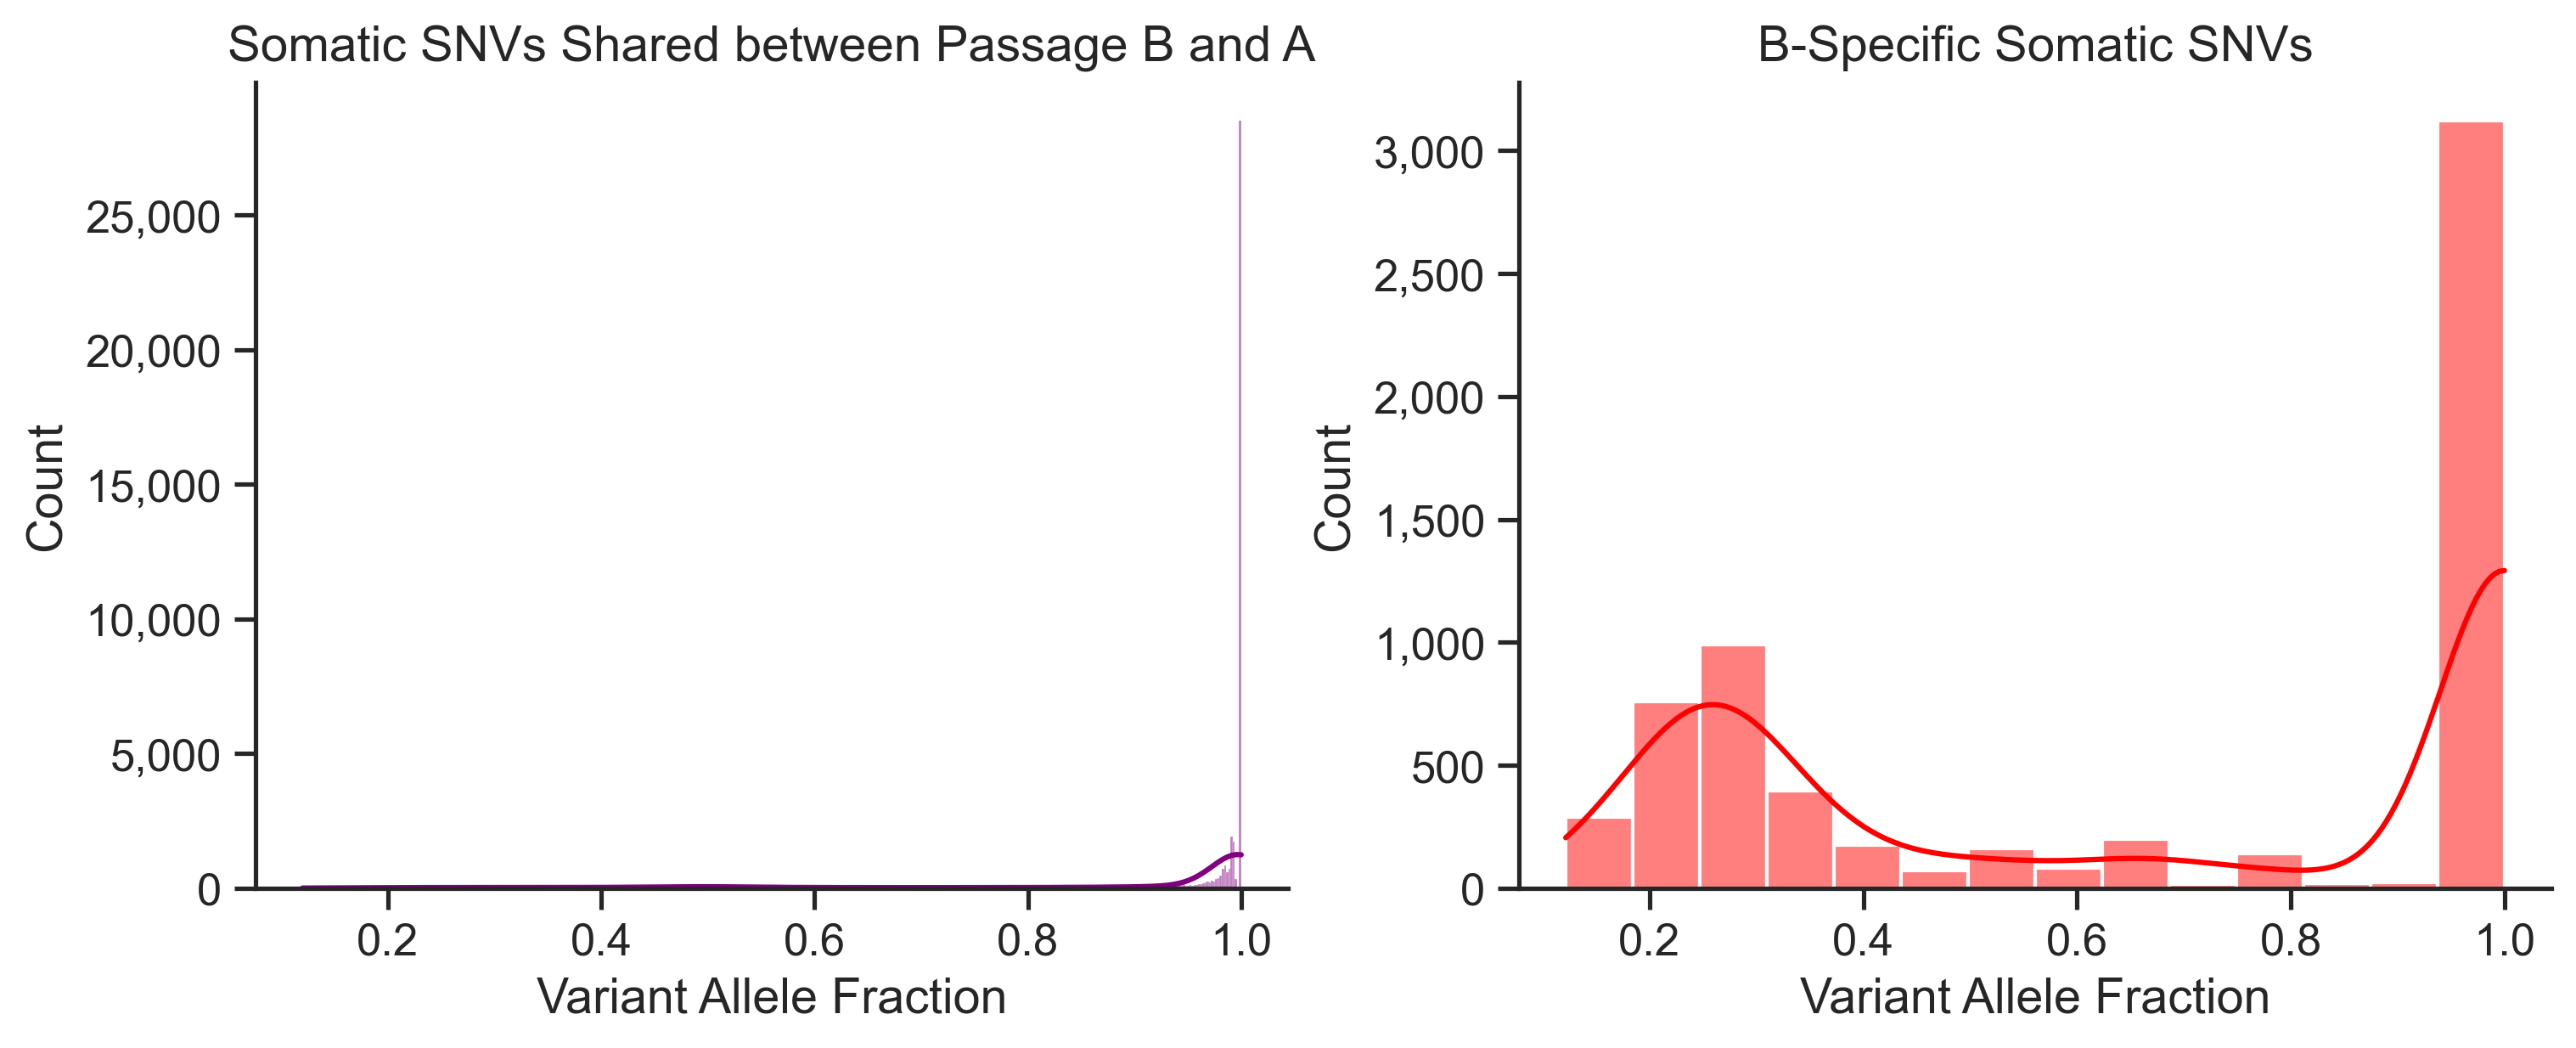

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
# INFO: COLO829T Passage B
## COLO829T Passage B Shared Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final[colotb_snvs_final['SNVid'].isin(colot_shared_finalset)], "VAF"), 
    kde=True,
    color='purple',
    ax=axes[0]).set_title("Somatic SNVs Shared between Passage B and A", fontsize=14)

axes[0].set_xlabel("Variant Allele Fraction")
axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.histplot(
    vcf_format_getter(colotb_snvs_final[colotb_snvs_final['SNVid'].isin(colotb_specific_finalset)], "VAF"), 
    kde=True, 
    color='red',
    ax=axes[1]).set_title("B-Specific Somatic SNVs", fontsize=14)
## COLO829T Passage B B-Specific Variants
axes[1].set_xlabel("Variant Allele Fraction")
axes[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

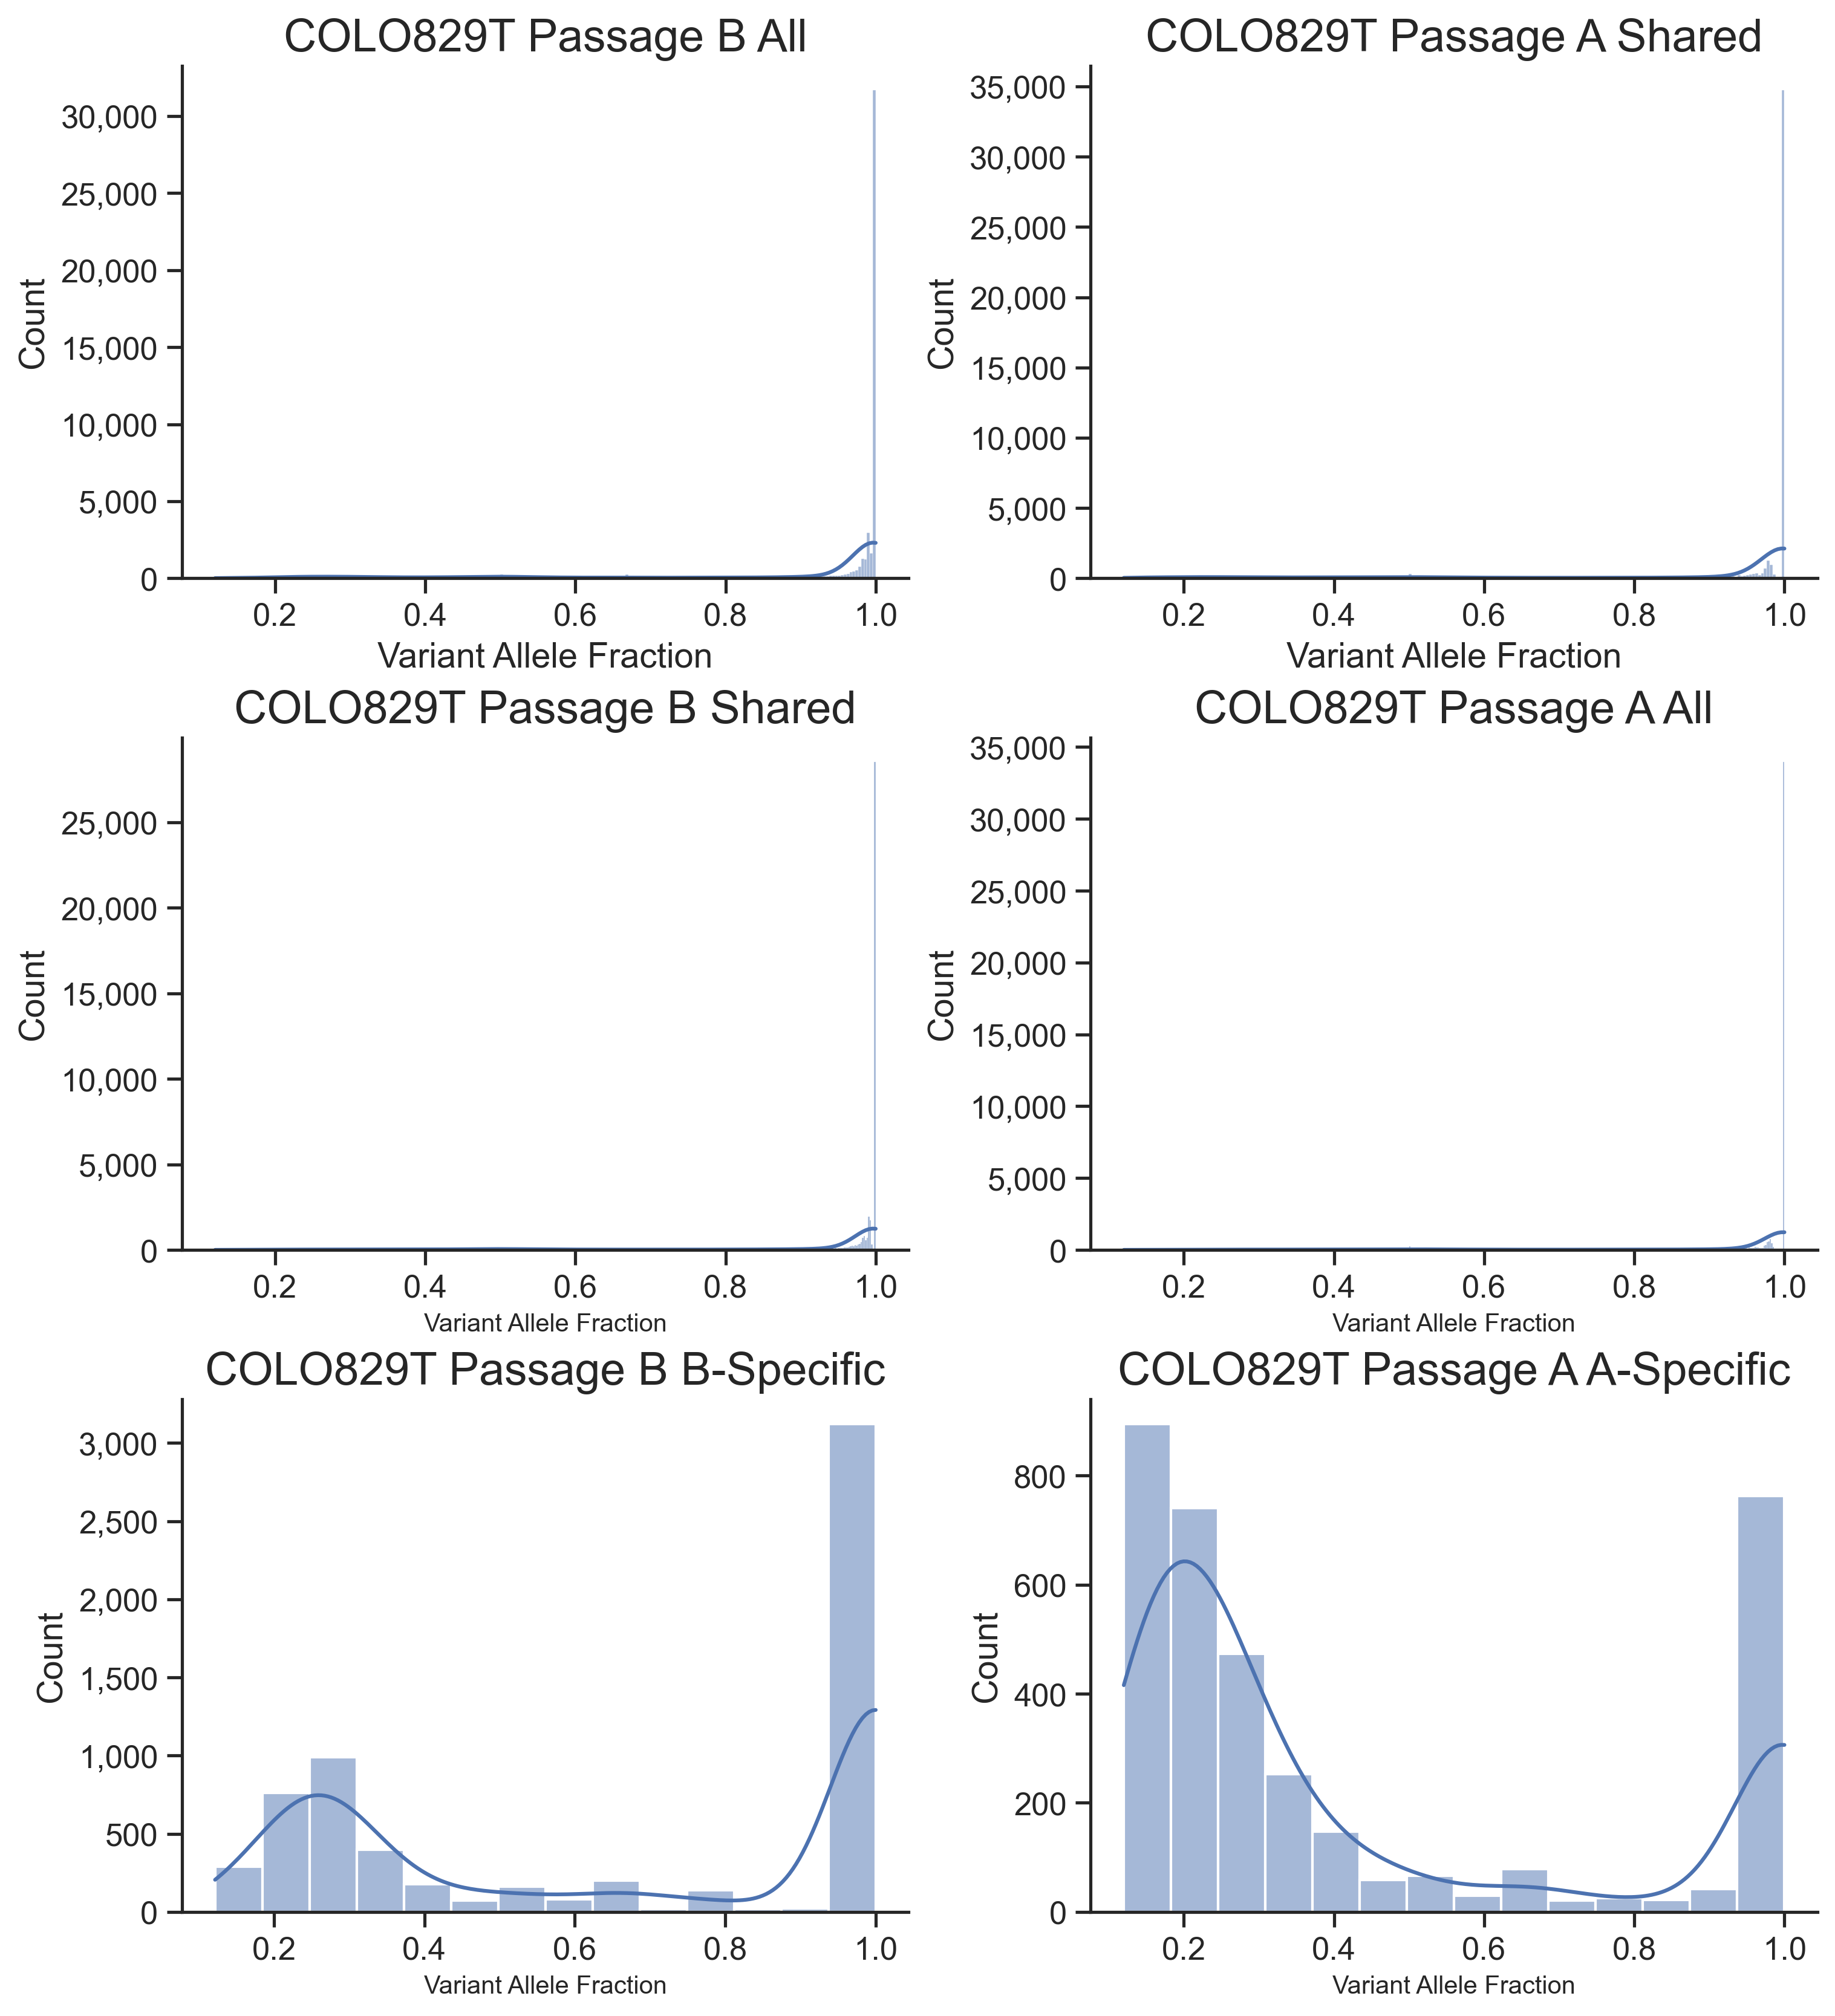

In [13]:
fig, axes = plt.subplots(3,2, figsize=(10,11), constrained_layout=True)
# INFO: COLO829T Passage B
## COLO829T Passage B All Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final, "VAF"), 
    kde=True, 
    ax=axes[0, 0]).set_title("COLO829T Passage B All", fontsize=18)

axes[0, 0].set_xlabel("Variant Allele Fraction")
axes[0, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage B Shared Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final[colotb_snvs_final['SNVid'].isin(colot_shared_finalset)], "VAF"), 
    kde=True, 
    ax=axes[1, 0]).set_title("COLO829T Passage B Shared", fontsize=18)

axes[1, 0].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[1, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage B B-Specific Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final[colotb_snvs_final['SNVid'].isin(colotb_specific_finalset)], "VAF"), 
    kde=True, 
    ax=axes[2, 0]).set_title("COLO829T Passage B B-Specific", fontsize=18)

axes[2, 0].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[2, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# INFO: COLO829T Passage A
## COLO829T Passage A All Variants
sns.histplot(
    vcf_format_getter(colota_snvs_final, "VAF"), 
    kde=True, 
    ax=axes[0, 1]).set_title("COLO829T Passage A Shared", fontsize=18)

axes[0, 1].set_xlabel("Variant Allele Fraction")
axes[0, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage A Shared Variants
sns.histplot(
    vcf_format_getter(colota_snvs_final[colota_snvs_final['SNVid'].isin(colot_shared_finalset)], "VAF"), 
    kde=True, 
    ax=axes[1, 1]).set_title("COLO829T Passage A All", fontsize=18)

axes[1, 1].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[1, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage A A-Specific Variants
sns.histplot(
    vcf_format_getter(colota_snvs_final[colota_snvs_final['SNVid'].isin(colota_specific_finalset)], "VAF"), 
    kde=True, 
    ax=axes[2, 1]).set_title("COLO829T Passage A A-Specific", fontsize=18)

axes[2, 1].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[2, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

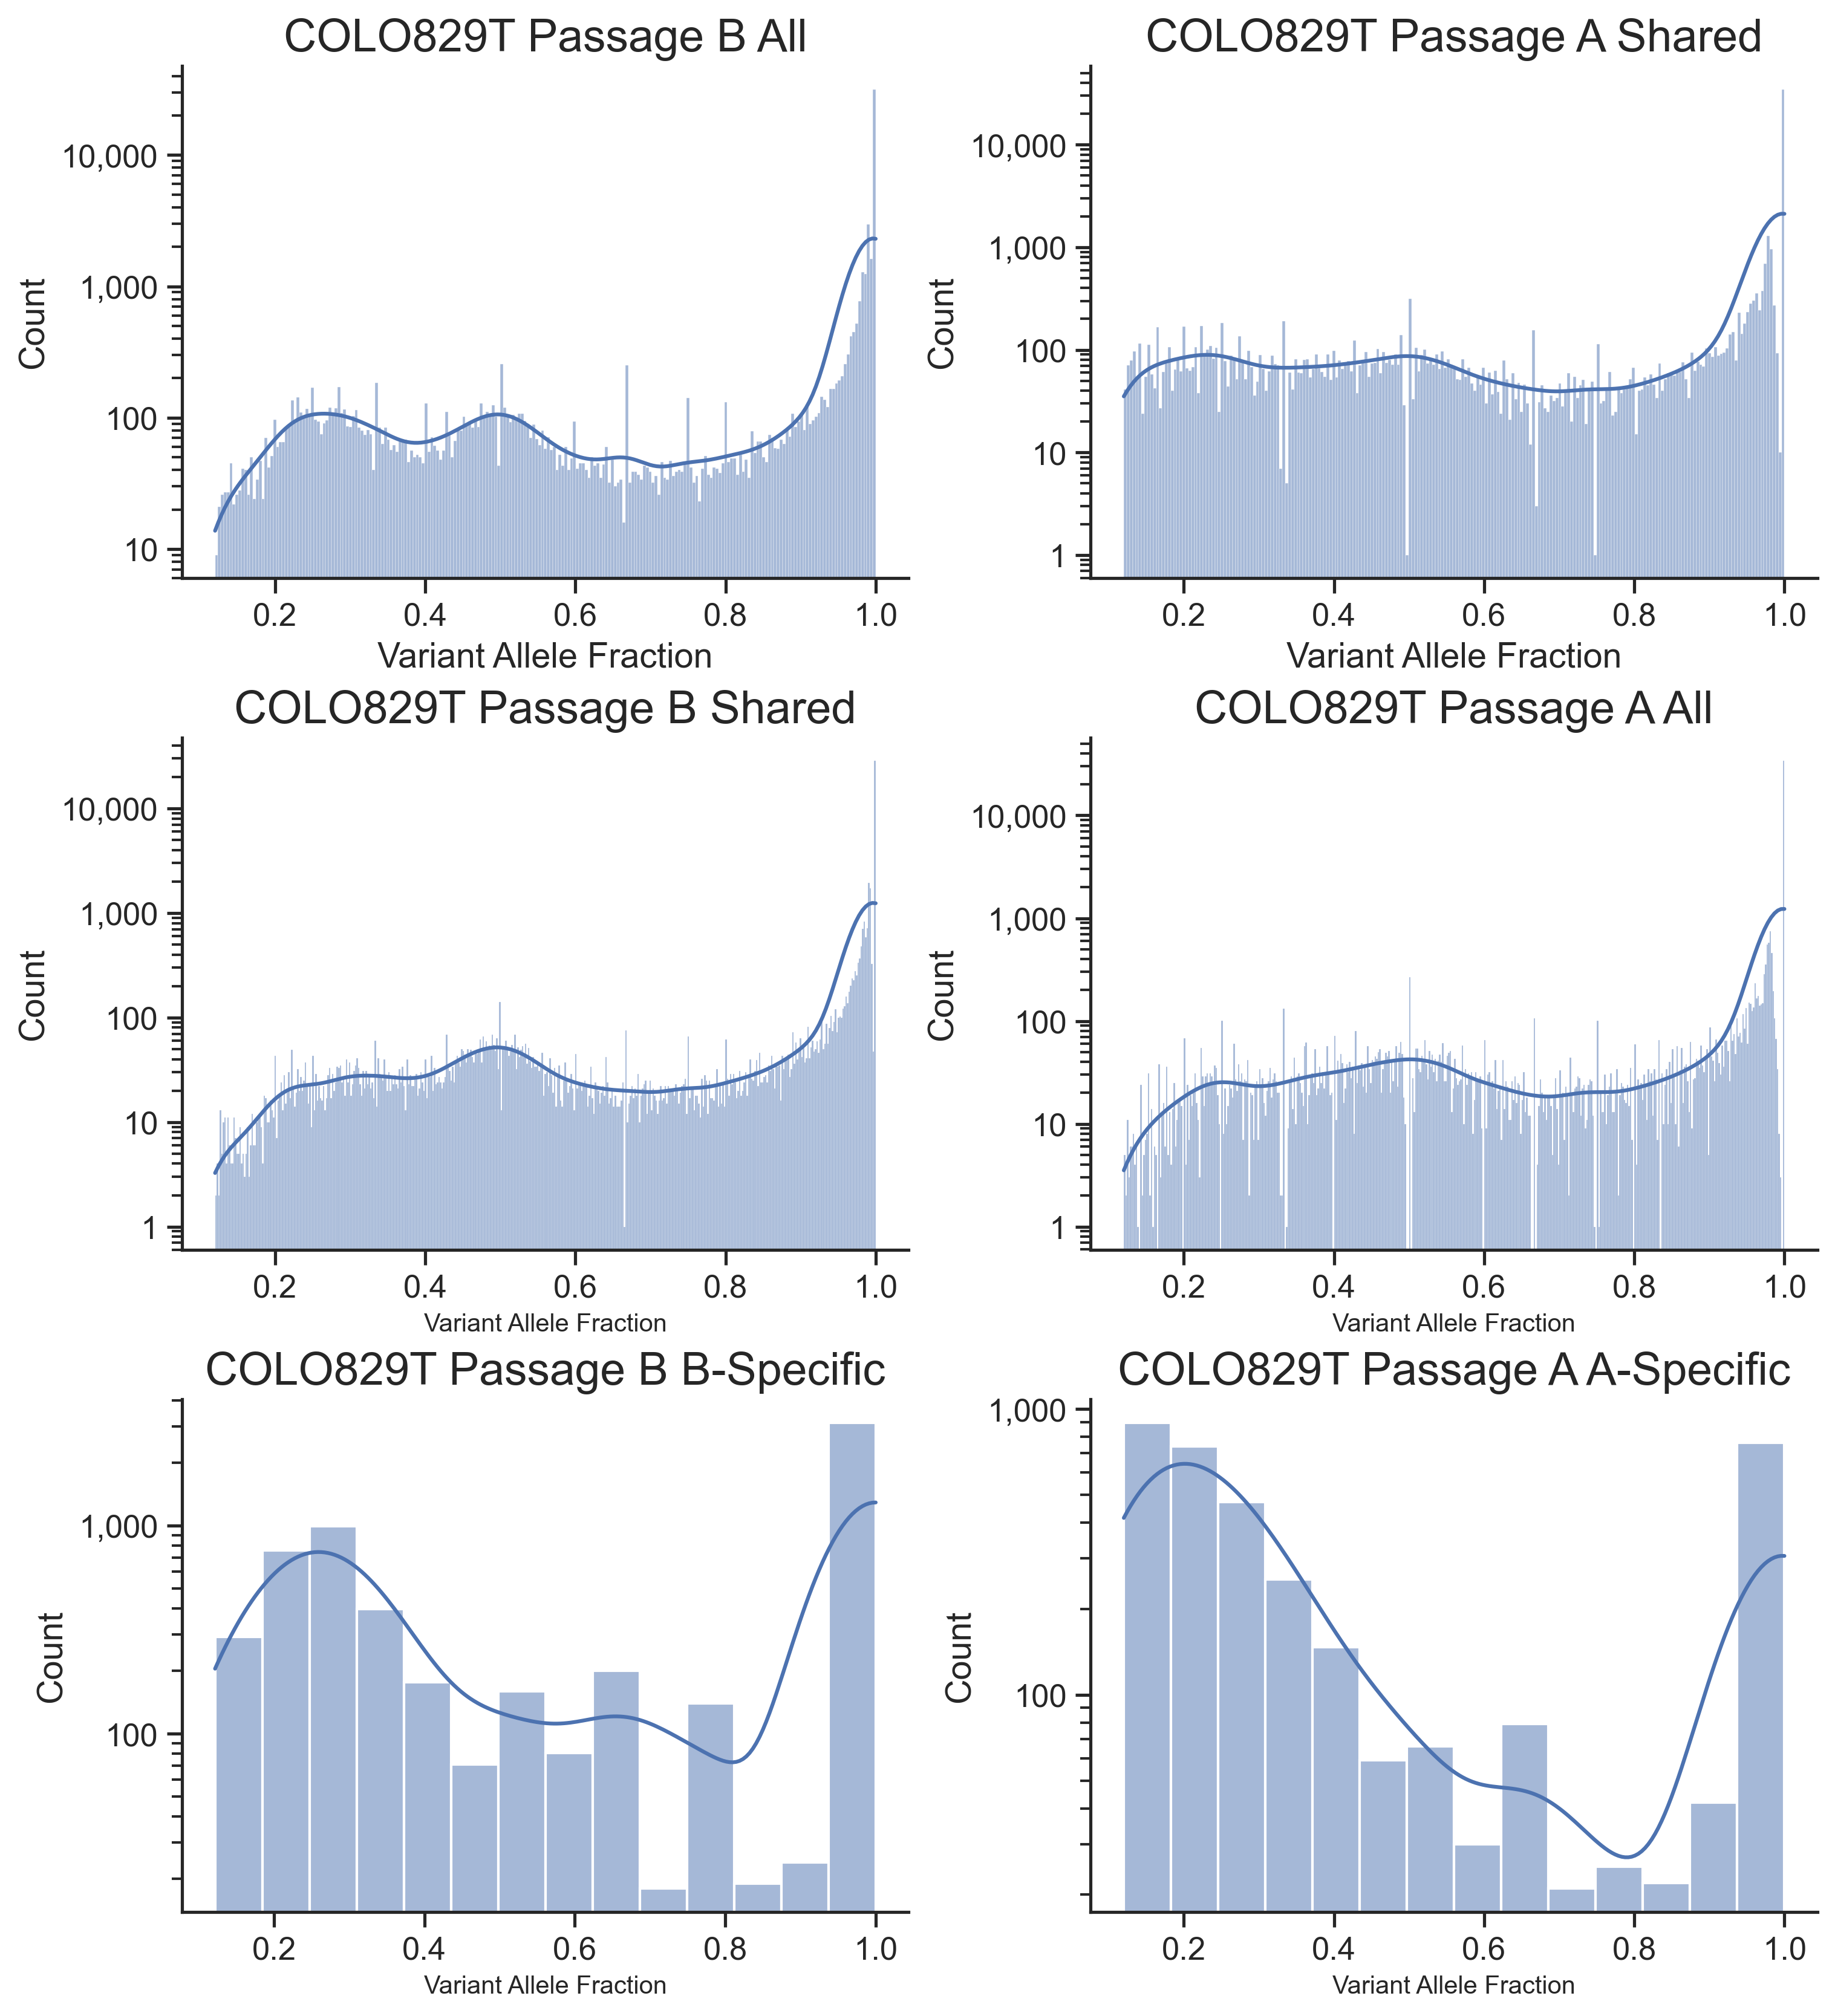

In [14]:
fig, axes = plt.subplots(3,2, figsize=(10,11), constrained_layout=True)
# INFO: COLO829T Passage B
## COLO829T Passage B All Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final, "VAF"), 
    kde=True, 
    ax=axes[0, 0]).set_title("COLO829T Passage B All", fontsize=18)

axes[0, 0].set_xlabel("Variant Allele Fraction")
axes[0, 0].set_yscale('log')
axes[0, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage B Shared Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final[colotb_snvs_final['SNVid'].isin(colot_shared_finalset)], "VAF"), 
    kde=True, 
    ax=axes[1, 0]).set_title("COLO829T Passage B Shared", fontsize=18)

axes[1, 0].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[1, 0].set_yscale('log')
axes[1, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage B B-Specific Variants
sns.histplot(
    vcf_format_getter(colotb_snvs_final[colotb_snvs_final['SNVid'].isin(colotb_specific_finalset)], "VAF"), 
    kde=True, 
    ax=axes[2, 0]).set_title("COLO829T Passage B B-Specific", fontsize=18)

axes[2, 0].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[2, 0].set_yscale('log')
axes[2, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# INFO: COLO829T Passage A
## COLO829T Passage A All Variants
sns.histplot(
    vcf_format_getter(colota_snvs_final, "VAF"), 
    kde=True, 
    ax=axes[0, 1]).set_title("COLO829T Passage A Shared", fontsize=18)

axes[0, 1].set_xlabel("Variant Allele Fraction")
axes[0, 1].set_yscale('log')
axes[0, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage A Shared Variants
sns.histplot(
    vcf_format_getter(colota_snvs_final[colota_snvs_final['SNVid'].isin(colot_shared_finalset)], "VAF"), 
    kde=True, 
    ax=axes[1, 1]).set_title("COLO829T Passage A All", fontsize=18)

axes[1, 1].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[1, 1].set_yscale('log')
axes[1, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## COLO829T Passage A A-Specific Variants
sns.histplot(
    vcf_format_getter(colota_snvs_final[colota_snvs_final['SNVid'].isin(colota_specific_finalset)], "VAF"), 
    kde=True, 
    ax=axes[2, 1]).set_title("COLO829T Passage A A-Specific", fontsize=18)

axes[2, 1].set_xlabel("Variant Allele Fraction", fontsize=10)
axes[2, 1].set_yscale('log')
axes[2, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## Orthogonal validation of Somatic SNVs by using UL-ONT pileup

In [15]:
"""
make_site_list(colotb_snvs_final,
               path=f'{dir}/VariantCalls_DeepVariant_1.6.1', 
               prefix="COLO829TB_SNVs_Somatic_PileupCheck")

os.system(f"cat \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TB_SNVs_Somatic_PileupCheck.sitelist \
            | sort | uniq | bedtools sort -i - > temp.sitelist")

os.system(f"mv \
          temp.sitelist \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TB_SNVs_Somatic_PileupCheck.sitelist")
"""

'\nmake_site_list(colotb_snvs_final,\n               path=f\'{dir}/VariantCalls_DeepVariant_1.6.1\', \n               prefix="COLO829TB_SNVs_Somatic_PileupCheck")\n\nos.system(f"cat           {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TB_SNVs_Somatic_PileupCheck.sitelist             | sort | uniq | bedtools sort -i - > temp.sitelist")\n\nos.system(f"mv           temp.sitelist           {dir}/VariantCalls_DeepVariant_1.6.1/COLO829TB_SNVs_Somatic_PileupCheck.sitelist")\n'

In [16]:
colotb_ulont_validate = read_vcf("/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/ONT/UL-ONT/COLO829TB_UL-ONT_Pileup_on_COLO829TB_SNVs_Somatic_PileupCheck.sitelist.norm.reheader.vcf.gz")

# colotb_snvs_final, colotb_snvs_shared_final, colotb_snvs_bspecific_final
# colota_snvs_final, colota_snvs_shared_final, colota_snvs_bspecific_final

colotb_ulont_validate['SNVid'] = colotb_ulont_validate[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colotb_ulont_validateset = set(colotb_ulont_validate['SNVid'])

print(f"For {len(colotb_snvs_finalset):,} COLO829T Passage B SNVs, {round(len(colotb_snvs_finalset.intersection(colotb_ulont_validateset)) * 100 / len(colotb_snvs_finalset), 2)}% are orthogonally validated by Ultra-long ONT")
print(f"For {len(colot_shared_finalset):,} Shared SNVs, {round(len(colot_shared_finalset.intersection(colotb_ulont_validateset)) * 100 / len(colot_shared_finalset), 2)}% are orthogonally validated by Ultra-long ONT")
print(f"For {len(colotb_specific_finalset):,} B-specific SNVs, {round(len(colotb_specific_finalset.intersection(colotb_ulont_validateset)) * 100 / len(colotb_specific_finalset), 2)}% of B-Specific SNVs are orthogonally validated by Ultra-long ONT")

For 57,140 COLO829T Passage B SNVs, 90.96% are orthogonally validated by Ultra-long ONT
For 50,689 Shared SNVs, 95.86% are orthogonally validated by Ultra-long ONT
For 6,451 B-specific SNVs, 52.49% of B-Specific SNVs are orthogonally validated by Ultra-long ONT


## DBS SNVs

Text(0.5, 0, 'Distance to the Nearest SNVs (Log 10)')

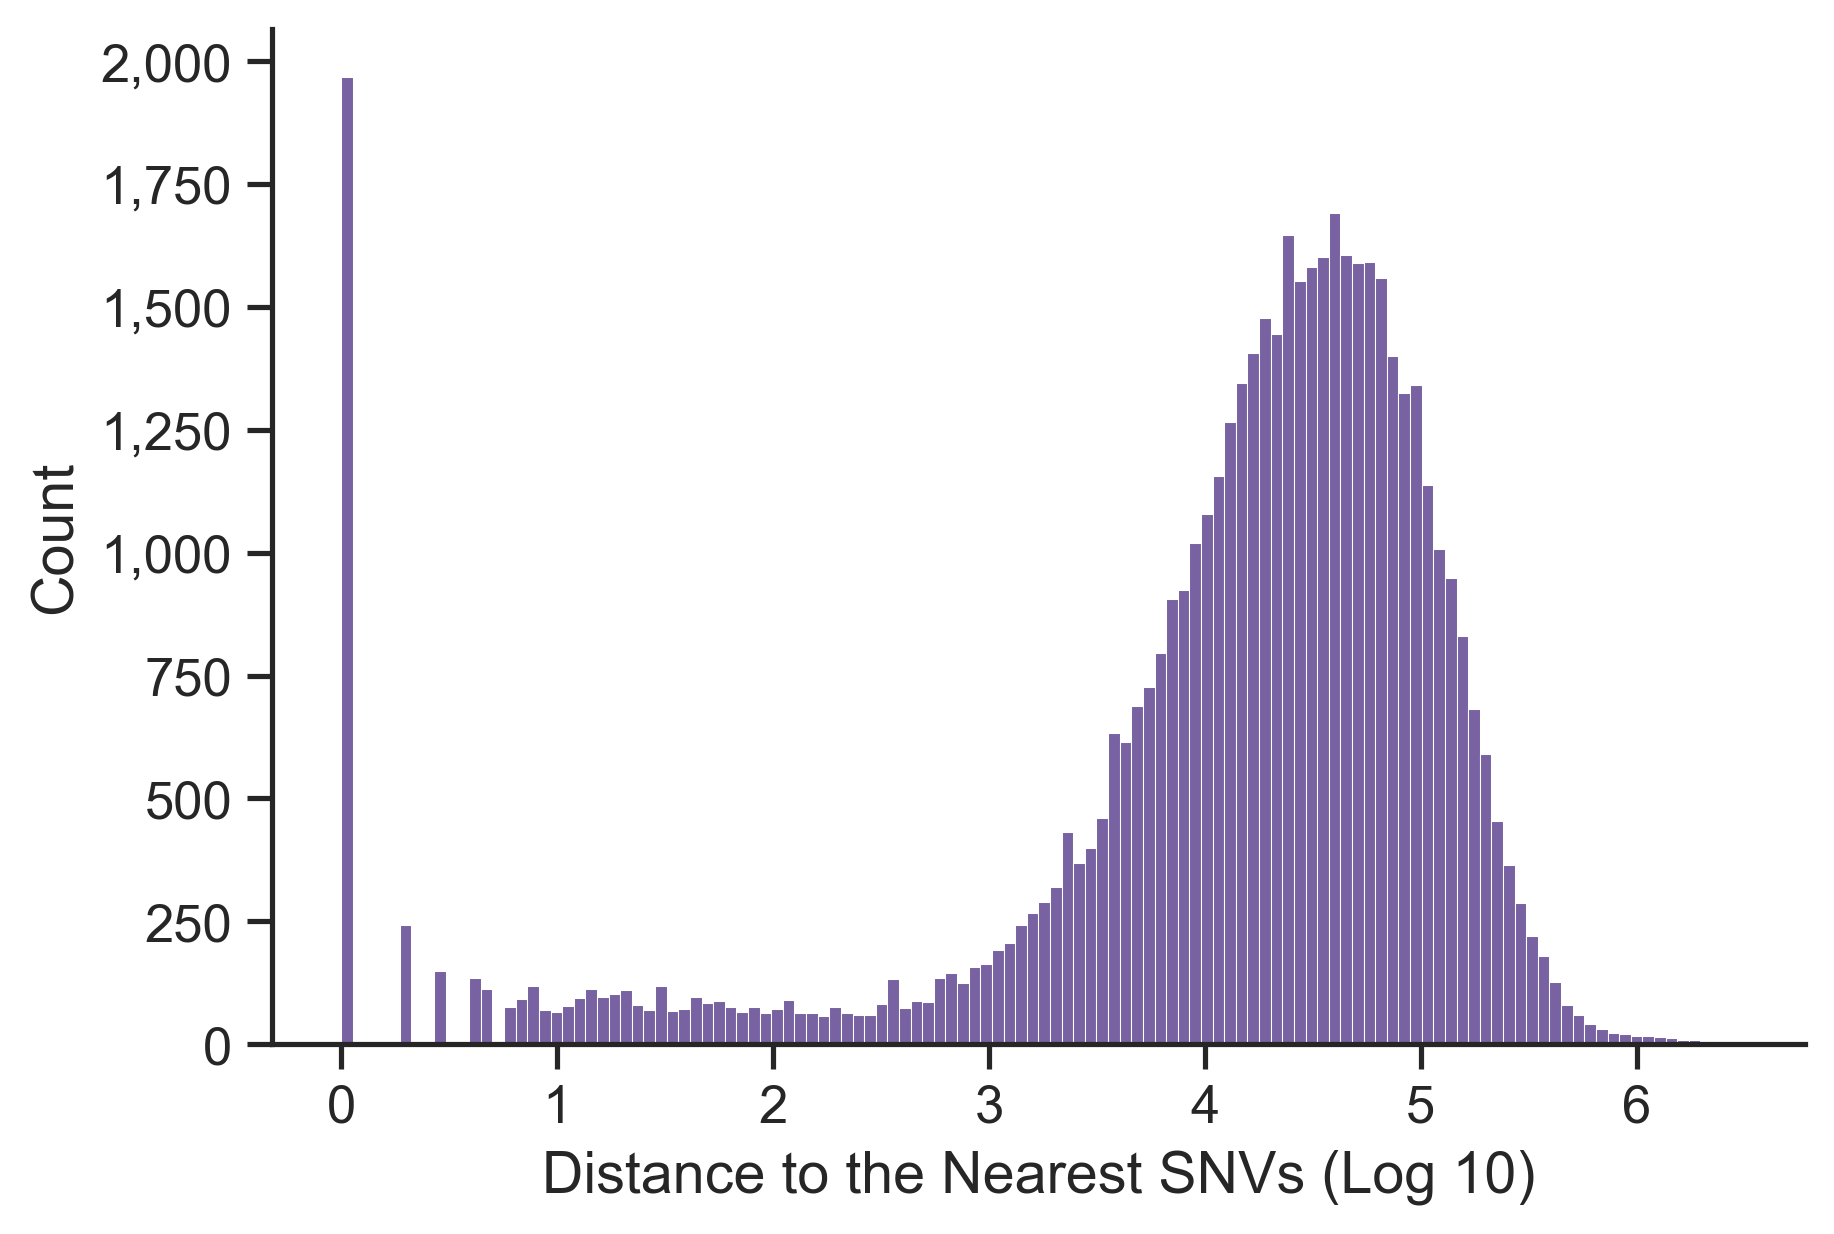

In [17]:
colotb_snvs_shared_final_nearest_distance = pd.concat([colotb_snvs_shared_final.groupby('CHROM')['POS'].diff(), colotb_snvs_shared_final.groupby('CHROM')['POS'].diff().shift(-1)], axis=1).min(axis=1)

fig, axes = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)
sns.histplot(np.log10(colotb_snvs_shared_final_nearest_distance), 
             color='#4B2E83', 
             ax=axes)
axes.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes.set_xlabel('Distance to the Nearest SNVs (Log 10)')

In [18]:
#pd.concat([colotb_snvs_shared_final.groupby('CHROM')['POS'].diff(), colotb_snvs_shared_final.groupby('CHROM')['POS'].diff().shift(-1)], axis=1)
list(vcf_info_getter(colotb_snvs_shared_final[colotb_snvs_shared_final.groupby("CHROM")['POS'].diff().shift(-1) == 1], "FIRE").dropna().values)

['peak_h1.4109',
 'peak_h1.4688',
 'peak_h1.49604',
 'peak_h1.106667',
 'peak_h1.114724',
 'peak_h2.4667',
 'peak_h2.6865',
 'peak_h2.78577',
 'peak_h2.113077']

## Makie Inputs for Mutational Spectrum Analysis

In [19]:
# colotb_snvs_final, colotb_snvs_shared_final, colotb_snvs_bspecific_final
# colota_snvs_final, colota_snvs_shared_final, colota_snvs_bspecific_final

In [20]:
"""
os.system(f"zcat '{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.vcf.gz' \
          | awk '/^##/' \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header")

# COLO829T Passage B
## All Passage B Variants
pre_vcf = colotb_snvs_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})
pre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.pre.vcf", sep='\t', index=False)

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.pre.vcf \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.final.vcf")

os.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.final.vcf \
          && tabix -p vcf {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.final.vcf.gz")

os.system(f"rm {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.pre.vcf")

## Shared Variants
pre_vcf = colotb_snvs_shared_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})
pre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.pre.vcf", sep='\t', index=False)

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.pre.vcf \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.vcf")

os.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.vcf \
          && tabix -p vcf {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.vcf.gz")

os.system(f"rm {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.pre.vcf")

## B-Specific variants
pre_vcf = colotb_snvs_bspecific_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})
pre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.b-specific.pre.vcf", sep='\t', index=False)

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.b-specific.pre.vcf \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.b-specific.final.vcf")

os.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.b-specific.final.vcf \
          && tabix -p vcf {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.b-specific.final.vcf.gz")

os.system(f"rm {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.b-specific.pre.vcf")

# COLO829T Passage A
## All Passage A Variants
pre_vcf = colota_snvs_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})
pre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.pre.vcf", sep='\t', index=False)

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.pre.vcf \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.final.vcf")

os.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.final.vcf \
          && tabix -p vcf {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.final.vcf.gz")

os.system(f"rm {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.pre.vcf")

## Shared Variants
pre_vcf = colota_snvs_shared_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})
pre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.shared.pre.vcf", sep='\t', index=False)

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.shared.pre.vcf \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.shared.final.vcf")

os.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.shared.final.vcf \
          && tabix -p vcf {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.shared.final.vcf.gz")

os.system(f"rm {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.shared.pre.vcf")

## B-Specific variants
pre_vcf = colota_snvs_aspecific_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})
pre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.a-specific.pre.vcf", sep='\t', index=False)

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header \
          {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.a-specific.pre.vcf \
          > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.a-specific.final.vcf")

os.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.a-specific.final.vcf \
          && tabix -p vcf {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.a-specific.final.vcf.gz")

os.system(f"rm {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.snv.annot.a-specific.pre.vcf")
"""

'\nos.system(f"zcat \'{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.vcf.gz\'           | awk \'/^##/\'           > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header")\n\n# COLO829T Passage B\n## All Passage B Variants\npre_vcf = colotb_snvs_final.iloc[:, :10].rename(columns={"CHROM": "#CHROM"})\npre_vcf.to_csv(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.pre.vcf", sep=\'\t\', index=False)\n\nos.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/pseudovcf_header           {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.pre.vcf           > {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.final.vcf")\n\nos.system(f"bgzip -f {dir}/VariantCalls_DeepVariant_1.6.1/Mutational_

# FIRE-associated SNV

In [21]:
colotb_snvs_shared_final[~vcf_info_getter(colotb_snvs_shared_final, "FIRE").isna()]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829T_PassageB_DSA,SNVid
18,haplotype1-0000001,2247871,.,C,T,63.5,PASS,Flagger=Hap;CpGi=CpGi_31.85;RM=Simple_repeat/u...,GT:GQ:DP:AD:VAF:PL,"1/1:57:114:0,114:1:63,58,0",haplotype1-0000001_2247871_C_T
106,haplotype1-0000001,11571782,.,C,T,68,PASS,Flagger=Hap;FIRE=peak_h1.499,GT:GQ:DP:AD:VAF:PL,"1/1:63:118:0,118:1:67,64,0",haplotype1-0000001_11571782_C_T
294,haplotype1-0000001,44065029,.,C,T,67.1,PASS,Flagger=Hap;FIRE=peak_h1.2670,GT:GQ:DP:AD:VAF:PL,"1/1:54:124:0,124:1:67,53,0",haplotype1-0000001_44065029_C_T
334,haplotype1-0000001,49738668,.,C,T,67.9,PASS,Flagger=Hap;CpGi=CpGi_479.92;RM=Low_complexity...,GT:GQ:DP:AD:VAF:PL,"1/1:63:101:0,101:1:67,64,0",haplotype1-0000001_49738668_C_T
447,haplotype1-0000001,71676768,.,G,A,65.9,PASS,Flagger=Hap;DM=SD6271;FIRE=peak_h1.4109,GT:GQ:DP:AD:VAF:PL,"1/1:56:132:0,132:1:65,56,0",haplotype1-0000001_71676768_G_A
...,...,...,...,...,...,...,...,...,...,...,...
49301,haplotype2-0000079,32623545,.,G,A,65.3,PASS,Flagger=Hap;FIRE=peak_h2.113366,GT:GQ:DP:AD:VAF:PL,"1/1:61:114:3,111:0.973684:65,62,0",haplotype2-0000079_32623545_G_A
49308,haplotype2-0000079,33710194,.,G,A,71.7,PASS,Flagger=Hap;CpGi=CpGi_56184.127;FIRE=peak_h2.1...,GT:GQ:DP:AD:VAF:PL,"1/1:62:89:0,89:1:71,62,0",haplotype2-0000079_33710194_G_A
49757,haplotype2-0000079,72376871,.,G,A,21.9,PASS,Flagger=Hap;RM=LTR/ERV1;FIRE=peak_h2.115012,GT:GQ:DP:AD:VAF:PL,"0/1:22:56:39,17:0.303571:21,0,46",haplotype2-0000079_72376871_G_A
50459,haplotype2-0000079,136599874,.,C,T,64.3,PASS,Flagger=Hap;RM=DNA/TcMar-Tigger;FIRE=peak_h2.1...,GT:GQ:DP:AD:VAF:PL,"1/1:61:44:1,43:0.977273:64,63,0",haplotype2-0000079_136599874_C_T


In [22]:
len(set(vcf_info_getter(colotb_snvs_shared_final, "FIRE").dropna().values))

255